## SALES ANALYSIS

### Introduction

The analysis aims to explore sales data to discover patterns and answer two main questions:

a) Is SalesAmount influenced by StandarCost, PromotionType, and ProductCategory?

b) If the company launches a new product, which customer group should be targeted in higher SalesTerritoryGroup?

To address these questions, the analysis will utilize Python libraries such as Pandas and PySpark. Additionally, machine learning algorithms like Random Forest and K-means will be employed for analysis and insights extraction.

### Import Libraries & Load Data

In [1]:
import os
working_directory = "C:/Users/aggel/OneDrive/Desktop/processing data autumn 2023/assigment/DataSet_final"
os.chdir(working_directory)
os.environ["PYSPARK_PYTHON"] = "python"

In [2]:
!pip freeze > requirements.txt

In [3]:
!pip install  -r requirements.txt

Processing c:\ci_311\bottleneck_1676500016583\work (from -r requirements.txt (line 3))


  ERROR: Cannot unpack file C:\ci_311\bottleneck_1676500016583\work (downloaded from C:\Users\aggel\AppData\Local\Temp\pip-install-i4_zh77p\bottleneck_5d4b951676f6491890410d6a8a69407c, content-type: None); cannot detect archive format
ERROR: Cannot determine archive format of C:\Users\aggel\AppData\Local\Temp\pip-install-i4_zh77p\bottleneck_5d4b951676f6491890410d6a8a69407c


In [4]:
import os
working_directory = "C:/Users/aggel/OneDrive/Desktop/processing data autumn 2023/assigment/DataSet_final"
os.chdir(working_directory)
os.environ["PYSPARK_PYTHON"] = "python"

In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName("sales").getOrCreate() 

In [7]:
# Load required datasets

customer  = spark.read.csv("./DimCustomer.csv", header=True, inferSchema=True)
product   = spark.read.csv("./DimProduct.csv", header=True, inferSchema=True)
category  = spark.read.csv("./DimProductCategory.csv", header=True, inferSchema=True)
subcat    = spark.read.csv("./DimProductSubcategory.csv", header=True , inferSchema=True)
promotion = spark.read.csv("./DimPromotion.csv", header=True, inferSchema=True)
territory = spark.read.csv("./DimSalesTerritory.csv", header=True, inferSchema=True)
int_sales = spark.read.csv ("./FactInternetSales.csv", header=True, inferSchema=True)

### DATA PREPROCESSING



In [8]:
# SELECT COLUMNS FOR ANALYSIS

product_col   = product.select("ProductKey", "ProductSubcategoryKey", "StandardCost")
customer_col  = customer.select("CustomerKey","GeographyKey", "Gender", "MaritalStatus", "YearlyIncome")
promotion_col = promotion.select("PromotionKey", "EnglishPromotionType", "DiscountPct")
territory_col = territory.select("SalesTerritoryKey", "SalesTerritoryGroup")
category_col  = category.select("ProductCategoryKey", "EnglishProductCategoryName")
subcat_col    = subcat.select("ProductSubcategoryKey","ProductCategoryKey")
intsales_col  = int_sales.select("ProductKey", "CustomerKey", "PromotionKey", "SalesTerritoryKey", "UnitPrice","SalesAmount")

In [9]:
#JOIN DATAFRAMES

merged = intsales_col.join(product_col, on='ProductKey', how="left").join(customer_col, on ='CustomerKey', how= 'left').join(promotion_col, on='PromotionKey', how="left").join(territory_col, on='SalesTerritoryKey', how="left")
merged = merged.distinct()

merged = merged.join(subcat_col, on='ProductSubcategoryKey', how="left")
merged = merged.distinct()

merged = merged.join(category_col, on="ProductCategoryKey", how="left")
merged = merged.distinct()


In [10]:
#DROP UNNECESSARY COLUMNS
columns_to_drop = [col_name for col_name in merged.columns if "key" in col_name.lower()]
merged = merged.drop(*columns_to_drop)


In [11]:
merged.printSchema()

root
 |-- UnitPrice: double (nullable = true)
 |-- SalesAmount: double (nullable = true)
 |-- StandardCost: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- EnglishPromotionType: string (nullable = true)
 |-- DiscountPct: double (nullable = true)
 |-- SalesTerritoryGroup: string (nullable = true)
 |-- EnglishProductCategoryName: string (nullable = true)



### Create new columns

Create 3 new columns to categorize :
1. Customers as high incomers and low incomers
2. Products as High Sales and Low Sales 
3. Individuals as Male or NotMale

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

mean_yearly_income = merged.agg(F.mean("YearlyIncome").alias("mean_yearly_income")).collect()[0]["mean_yearly_income"]
print("Mean Yearly Income:", mean_yearly_income)


merged = merged.withColumn(
    "IncomeCategory",
    F.when(F.col("YearlyIncome") > mean_yearly_income, 1).otherwise(0)
)

Mean Yearly Income: 59514.464557604464


In [13]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
mean_sales_amount = merged.agg(F.mean('SalesAmount').alias('mean_sales_amount')).collect()[0]['mean_sales_amount']

print("Mean Sales Amount:", mean_sales_amount)

merged = merged.withColumn('SalesAmountCategory', F.when(merged['SalesAmount'] < mean_sales_amount, 0).otherwise(1))

Mean Sales Amount: 496.2255983878869


In [14]:
from pyspark.sql.functions import when
merged = merged.withColumn("Male", when(merged["Gender"] == "M", 0).otherwise(1))

merged = merged.withColumn("MaritalStatusCode", when(merged["MaritalStatus"] == "S", 0).otherwise(1))

DATA CLEANING

In [16]:
#Unique Values 0f each column

for column_name in merged.columns:
    unique_values = merged.select(column_name).distinct().collect()
    unique_values_list = [row[column_name] for row in unique_values]
    
    print(f"Column: {column_name}, Unique Values: {unique_values_list}")

Column: UnitPrice, Unique Values: [3374.99, 21.49, 782.99, 8.99, 699.0982, 1214.85, 9.99, 742.35, 3578.27, 54.99, 35.0, 120.0, 7.95, 69.99, 2071.4196, 2384.07, 4.99, 769.49, 53.99, 1700.99, 2294.99, 24.49, 2443.35, 3.99, 1120.49, 2049.0982, 159.0, 63.5, 32.6, 2181.5625, 21.98, 2319.99, 29.99, 28.99, 3399.99, 1000.4375, 24.99, 49.99, 2.29, 34.99, 539.99, 564.99]
Column: SalesAmount, Unique Values: [3374.99, 21.49, 782.99, 8.99, 699.0982, 1214.85, 9.99, 742.35, 3578.27, 54.99, 35.0, 120.0, 7.95, 69.99, 2071.4196, 2384.07, 4.99, 769.49, 53.99, 1700.99, 2294.99, 24.49, 2443.35, 3.99, 1120.49, 2049.0982, 159.0, 63.5, 32.6, 2181.5625, 21.98, 2319.99, 29.99, 28.99, 3399.99, 1000.4375, 24.99, 49.99, 2.29, 34.99, 539.99, 564.99]
Column: StandardCost, Unique Values: [1.4923, 1518.7864, 13.0863, 3.3623, 343.6496, 23.749, 294.5797, 1481.9379, 20.5663, 59.466, 41.5723, 1.8663, 6.9223, 1082.51, 0.8565, 1251.9813, 461.4448, 1265.6195, 11.2163, 1912.1544, 308.2179, 8.2205, 755.1508, 26.1763, 3.7363, 1

In [17]:
# Missing Values

from pyspark.sql.functions import count, when, isnull

missing_values_count = merged.select([count(when(isnull(c), c)).alias(c) for c in merged.columns])

missing_values_count.show()

+---------+-----------+------------+------+-------------+------------+--------------------+-----------+-------------------+--------------------------+--------------+-------------------+----+-----------------+
|UnitPrice|SalesAmount|StandardCost|Gender|MaritalStatus|YearlyIncome|EnglishPromotionType|DiscountPct|SalesTerritoryGroup|EnglishProductCategoryName|IncomeCategory|SalesAmountCategory|Male|MaritalStatusCode|
+---------+-----------+------------+------+-------------+------------+--------------------+-----------+-------------------+--------------------------+--------------+-------------------+----+-----------------+
|        0|          0|           0|     0|            0|           0|                   0|          0|                  0|                         0|             0|                  0|   0|                0|
+---------+-----------+------------+------+-------------+------------+--------------------+-----------+-------------------+--------------------------+--------------

In [18]:
merged_pandas = merged.toPandas()

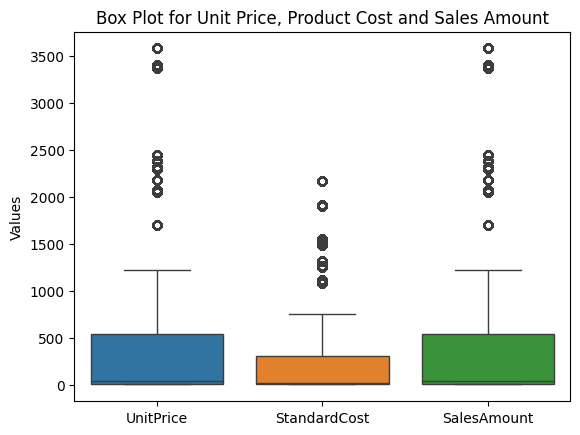

In [27]:
#Check for Outliers by Plot the numeric values#

import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = ["UnitPrice", "StandardCost", "SalesAmount"]

numeric_data    = merged.select(*numeric_columns).toPandas()

sns.boxplot(data=numeric_data)
plt.title("Box Plot for Unit Price, Product Cost and Sales Amount")
plt.ylabel("Values")
plt.show()


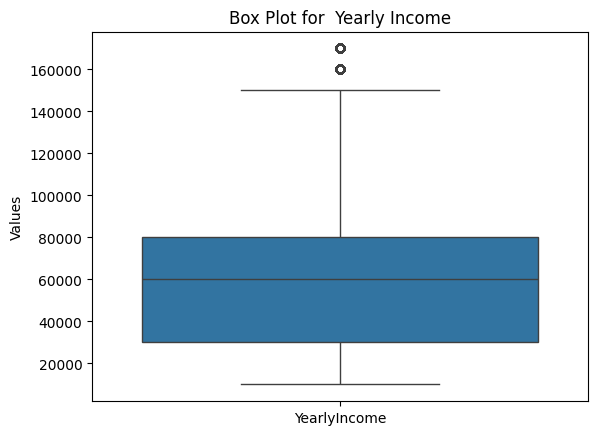

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = ["YearlyIncome"]

numeric_data    = merged.select(*numeric_columns).toPandas()

sns.boxplot(data=numeric_data)
plt.title("Box Plot for  Yearly Income")
plt.ylabel("Values")
plt.show()


In [23]:
## Remove outliers from numeric columns


from pyspark.sql import functions as F

numeric_columns = ["SalesAmount", "StandardCost", "UnitPrice", "YearlyIncome"]

def remove_outliers(df, column):
    quartiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    q1  = quartiles[0]
    q3  = quartiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return df.filter((df[column] >= lower_bound) & (df[column] <= upper_bound))

merged_without_outliers = merged
for column in numeric_columns:
    merged_without_outliers = remove_outliers(merged_without_outliers, column)




In [28]:
for column_name in merged_without_outliers.columns:
    unique_values      = merged_without_outliers.select(column_name).distinct().collect()
    unique_values_list = [row[column_name] for row in unique_values]
    
    print(f" {column_name}, Unique Values: {unique_values_list}")

 UnitPrice, Unique Values: [21.49, 8.99, 9.99, 54.99, 35.0, 63.5, 7.95, 69.99, 4.99, 32.6, 24.49, 3.99, 2.29, 34.99, 21.98, 29.99, 28.99, 24.99]
 SalesAmount, Unique Values: [21.49, 8.99, 9.99, 54.99, 35.0, 63.5, 7.95, 69.99, 4.99, 32.6, 24.49, 3.99, 2.29, 34.99, 21.98, 29.99, 28.99, 24.99]
 StandardCost, Unique Values: [1.4923, 13.0863, 3.3623, 23.749, 20.5663, 1.8663, 6.9223, 0.8565, 11.2163, 8.2205, 26.1763, 3.7363, 10.8423, 13.09, 9.1593, 12.1924, 9.3463, 8.0373, 2.9733]
 Gender, Unique Values: ['F', 'M']
 MaritalStatus, Unique Values: ['M', 'S']
 YearlyIncome, Unique Values: [130000, 100000, 30000, 150000, 10000, 60000, 120000, 110000, 20000, 80000, 50000, 90000, 70000, 40000]
 EnglishPromotionType, Unique Values: ['No Discount', 'Volume Discount']
 DiscountPct, Unique Values: [0.0, 0.02]
 SalesTerritoryGroup, Unique Values: ['Europe', 'North America', 'Pacific']
 EnglishProductCategoryName, Unique Values: ['Clothing', 'Accessories']
 IncomeCategory, Unique Values: [1, 0]
 SalesAm

EDA ANALYSIS 

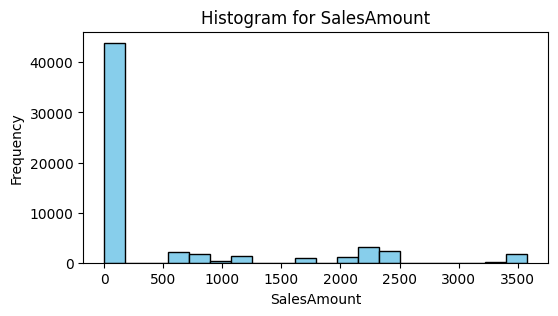

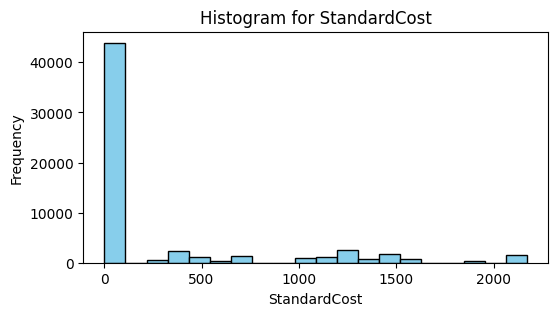

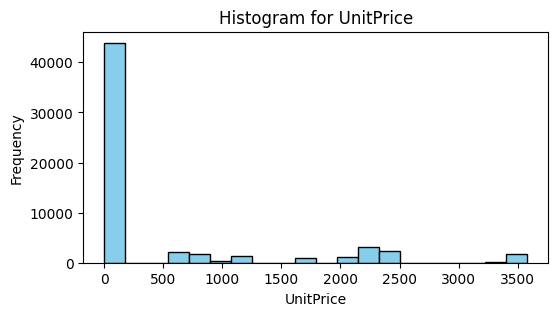

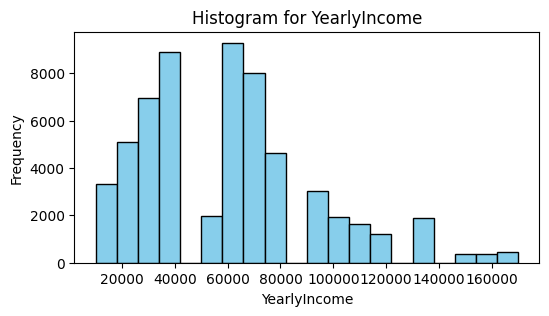

In [31]:
## Create histograms for numeric values to check the distribution

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

numeric_columns = ['SalesAmount', 'StandardCost', 'UnitPrice', 'YearlyIncome']

pandas_df = merged.select(numeric_columns).toPandas()

for column in numeric_columns:
    plt.figure(figsize=(6, 3))
    plt.hist(pandas_df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [32]:
merged_pandas.describe()

,UnitPrice,SalesAmount,StandardCost,YearlyIncome,DiscountPct,IncomeCategory,SalesAmountCategory,Male,MaritalStatusCode
count,59110.000000,59110.000000,59110.000000,59110.000000,59110.000000,59110.000000,59110.000000,59110.000000,59110.000000
mean,496.225598,496.225598,292.087030,59514.464558,0.000804,0.555794,0.257182,0.497412,0.547928
std,935.824319,935.824319,556.819664,33157.311165,0.005473,0.496881,0.437084,0.499998,0.497702
min,2.290000,2.290000,0.856500,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.990000,8.990000,3.362300,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.600000,32.600000,12.192400,60000.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,539.990000,539.990000,308.217900,80000.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,3578.270000,3578.270000,2171.294200,170000.000000,0.200000,1.000000,1.000000,1.000000,1.000000


PLOTING THE VARIABLES 

Explore for relationships and patterns between the variables

In [33]:
correlation_df = merged_pandas[numeric_columns]
spearman_correlation = correlation_df.corr(method='spearman')
print("Spearman correlation matrix:")
print(spearman_correlation)

Spearman correlation matrix:
              SalesAmount  StandardCost  UnitPrice  YearlyIncome
SalesAmount      1.000000      0.997591   1.000000      0.050177
StandardCost     0.997591      1.000000   0.997591      0.047489
UnitPrice        1.000000      0.997591   1.000000      0.050177
YearlyIncome     0.050177      0.047489   0.050177      1.000000


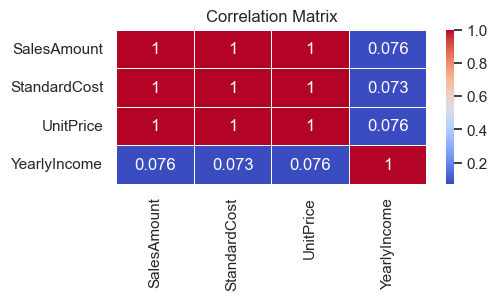

In [34]:
correlation_matrix = correlation_df.corr()
sns.set(style="white") 
plt.figure(figsize=(5, 2))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

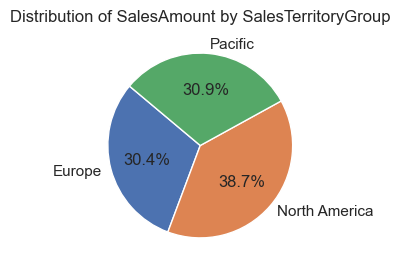

In [35]:
group_column = "SalesTerritoryGroup"
value_column = "SalesAmount"

grouped_sales = merged_pandas.groupby(group_column)[value_column].sum()
plt.figure(figsize=(6, 3))
plt.pie(grouped_sales, labels=grouped_sales.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of {value_column} by {group_column}')
plt.show()

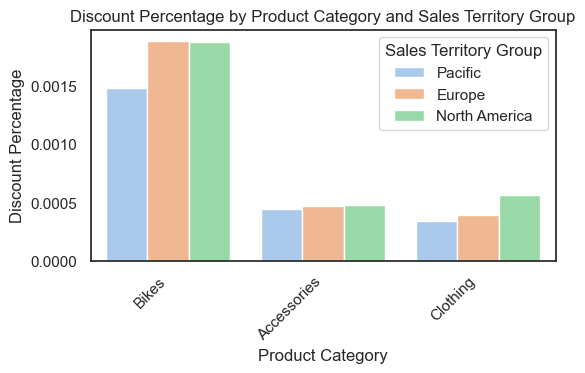

In [37]:
plt.figure(figsize=(6, 3))
sns.barplot(data=merged_pandas, x='EnglishProductCategoryName', y='DiscountPct', hue='SalesTerritoryGroup', errorbar=None, palette="pastel")
plt.title('Discount Percentage by Product Category and Sales Territory Group')
plt.xlabel('Product Category')
plt.ylabel('Discount Percentage')
plt.legend(title='Sales Territory Group', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.show()


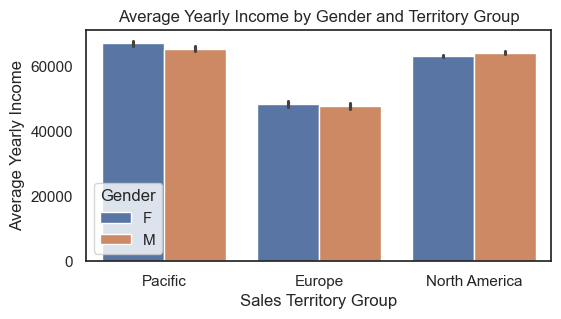

In [38]:
plt.figure(figsize=(6, 3))
sns.barplot(data=merged_pandas, x='SalesTerritoryGroup', y='YearlyIncome', hue='Gender', estimator='mean')
plt.title('Average Yearly Income by Gender and Territory Group')
plt.xlabel('Sales Territory Group')
plt.ylabel('Average Yearly Income')
plt.legend(title='Gender')
plt.show()

#### Random Forest Analysis 

 Does the total product cost, promotion type and product category influence sales amount?

 
In this section a regression analysis using Random Forest has been conducted to predict sales amounts based on product category, standard cost, and promotion type. 

It encodes categorical variables, assembles feature vectors, splits data, builds a regression model, evaluates performance, and reveals feature importance.

In [39]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

indexer_category = StringIndexer(inputCol="EnglishProductCategoryName", outputCol="EnglishProductCategoryName_index").fit(merged)
indexer_promotion = StringIndexer(inputCol="EnglishPromotionType", outputCol="EnglishPromotionType_index").fit(merged)

feature_columns = ["EnglishProductCategoryName_index", "StandardCost", "EnglishPromotionType_index"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

(training_data, test_data) = merged.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(labelCol="SalesAmount", featuresCol="features")

pipeline = Pipeline(stages=[indexer_category, indexer_promotion, assembler, rf])

model = pipeline.fit(training_data)

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="SalesAmount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

feature_importance = model.stages[-1].featureImportances
print("Feature Importance:", feature_importance)


Root Mean Squared Error (RMSE) on test data = 247.77157933211197
Feature Importance: (3,[0,1,2],[0.44996761322972156,0.48059883624444827,0.0694335505258302])


### K MEANS 

 If the company launches a new product which customer’s group should target in higher SalesTerritoryGroup?

 To answer this question firstly segment customers from 'North America' territory which is the higher SalesTerritotyGroup (line 24)

In [46]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

selected_territory_group = 'North America'
filtered_df = merged_pandas[merged_pandas['SalesTerritoryGroup'] == selected_territory_group]

selected_columns = ['SalesAmount', 'MaritalStatusCode', 'IncomeCategory', 'Male']

features = filtered_df[selected_columns]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

num_clusters = 2

kmeans = KMeans(n_init=10, n_clusters=num_clusters, random_state=42)
filtered_df.loc[:, 'Cluster'] = kmeans.fit_predict(scaled_features)

cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=selected_columns)
print("Cluster Centers:")
print(cluster_centers)

cluster_counts = filtered_df['Cluster'].value_counts().sort_index()
print("\nNumber of Customers in Each Cluster:")
print(cluster_counts)

merged_pandas.loc[merged_pandas['SalesTerritoryGroup'] == selected_territory_group, 'Cluster'] = filtered_df['Cluster']

print("\nResulting DataFrame with Clusters:")
print(merged_pandas)


Cluster Centers:
   SalesAmount  MaritalStatusCode  IncomeCategory      Male
0   454.780891      -2.031708e-14        0.628315  0.542128
1   369.013631       1.000000e+00        0.703625  0.463031

Number of Customers in Each Cluster:
Cluster
0.0    11916
1.0    16081
Name: count, dtype: int64

Resulting DataFrame with Clusters:
       UnitPrice  SalesAmount  StandardCost Gender MaritalStatus  \
0        3578.27      3578.27     2171.2942      F             M   
1        3578.27      3578.27     2171.2942      M             M   
2        3578.27      3578.27     2171.2942      M             M   
3        3578.27      3578.27     2171.2942      F             S   
4        3578.27      3578.27     2171.2942      M             S   
...          ...          ...           ...    ...           ...   
59105       4.99         4.99        1.8663      F             M   
59106       3.99         3.99        1.4923      F             S   
59107       9.99         9.99        3.7363      M       

In [45]:
# Descriptive Statistics
cluster_statistics = merged_pandas.groupby('Cluster').agg({
    'SalesAmount' : ['mean', 'median', 'std', 'min', 'max'],
    'YearlyIncome': ['mean', 'median', 'std', 'min', 'max'],
}).reset_index()

print(cluster_statistics)

  Cluster SalesAmount                                    YearlyIncome  \
                 mean median         std   min      max          mean   
0     0.0  454.780891  29.99  920.095508  2.29  3578.27  62306.982209   
1     1.0  369.013631  28.99  824.128566  2.29  3578.27  64666.376469   

                                         
    median           std    min     max  
0  60000.0  25557.454317  10000  170000  
1  60000.0  24614.989454  10000  170000  


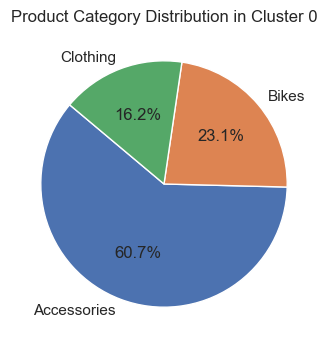

In [42]:
import matplotlib.pyplot as plt

cluster_1_df = merged_pandas[merged_pandas['Cluster'] == 0]

category_counts_cluster_1 = cluster_1_df['EnglishProductCategoryName'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(category_counts_cluster_1, labels=category_counts_cluster_1.index, autopct='%1.1f%%', startangle=140)
plt.title('Product Category Distribution in Cluster 0')
plt.show()


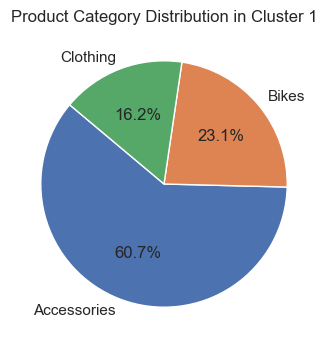

In [43]:
import matplotlib.pyplot as plt

cluster_1_df = merged_pandas[merged_pandas['Cluster'] == 0]

category_counts_cluster_1 = cluster_1_df['EnglishProductCategoryName'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(category_counts_cluster_1, labels=category_counts_cluster_1.index, autopct='%1.1f%%', startangle=140)
plt.title('Product Category Distribution in Cluster 1')
plt.show()


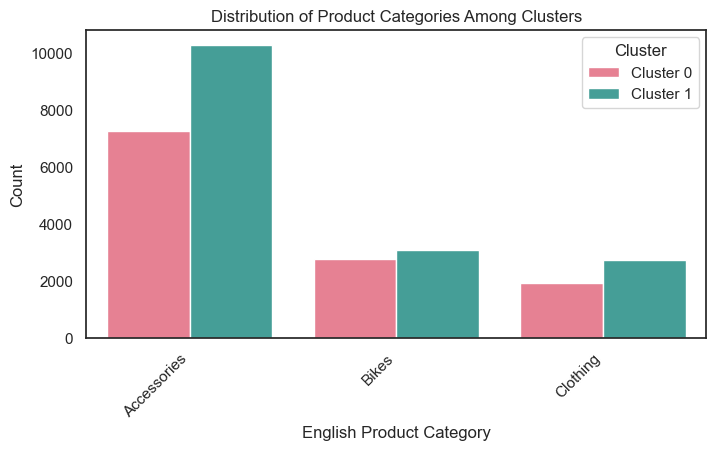

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_0_df = merged_pandas[merged_pandas['Cluster'] == 0]
cluster_1_df = merged_pandas[merged_pandas['Cluster'] == 1]

category_counts_cluster_0 = cluster_0_df['EnglishProductCategoryName'].value_counts()
category_counts_cluster_1 = cluster_1_df['EnglishProductCategoryName'].value_counts()

category_counts_df = pd.DataFrame({
    'Category': category_counts_cluster_0.index,
    'Cluster 0': category_counts_cluster_0.values,
    'Cluster 1': category_counts_cluster_1.values
}).fillna(0) 

plt.figure(figsize=(8, 4))
sns.barplot(data=category_counts_df.melt('Category', var_name='Cluster', value_name='Count'), 
            x='Category', y='Count', hue='Cluster', palette='husl')
plt.xlabel('English Product Category')
plt.ylabel('Count')
plt.title('Distribution of Product Categories Among Clusters')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.show()
